# Synthetic Clear Sky

In this notebook, we generate a synthetic power signal for a system located in souther California. We make use of the `pvlib-python` PV modeling package. The goal is to compare the solar eigenvectors generated by this method to the eigenvectors generated from real data.

In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

Load the Sandia module and CEC inverter databases.

In [2]:
# load some module and inverter specifications
sandia_modules = retrieve_sam('SandiaMod')
cec_inverters = retrieve_sam('cecinverter')

sandia_module = sandia_modules['SunPower_SP305_GEN_C_Module__2008__E__']
cec_inverter = cec_inverters['SMA_America__SB3000US_240V__CEC_2007_']

Set up the system and location  model chain.

In [3]:
location = Location(latitude=33.68, longitude=-117.82, altitude=60, tz='America/Los_Angeles')
system = PVSystem(surface_tilt=30, surface_azimuth=100,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)
mc = ModelChain(system, location)

Create the time index for the simulated data.

In [4]:
times = pd.DatetimeIndex(start='2016-01-01', end='2017-01-01', freq='5min', tz=location.tz)

In [5]:
try:
    mc.run_model(times=times)
except KeyError as e:
    print e

"['ghi' 'dni' 'dhi'] not in index"


In [6]:
mc.weather = pd.DataFrame(columns=['ghi', 'dni', 'dhi'], index=times)

In [7]:
weather = mc.location.get_clearsky(
                times, mc.clearsky_model,
                zenith_data=mc.solar_position['apparent_zenith'],
                airmass_data=mc.airmass['airmass_absolute'])

In [8]:
weather = pd.DataFrame(weather, index=times)

In [9]:
weather['wind_speed'] = 0.
weather['temp_air'] = 20.

In [10]:
try:
    mc.run_model(times=times, weather=weather)
except TypeError as e:
    print e

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/pvlib/pvsystem.py:1283: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/pvlib/pvsystem.py:1289: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


Below we inspect a single day in the simulated data set.

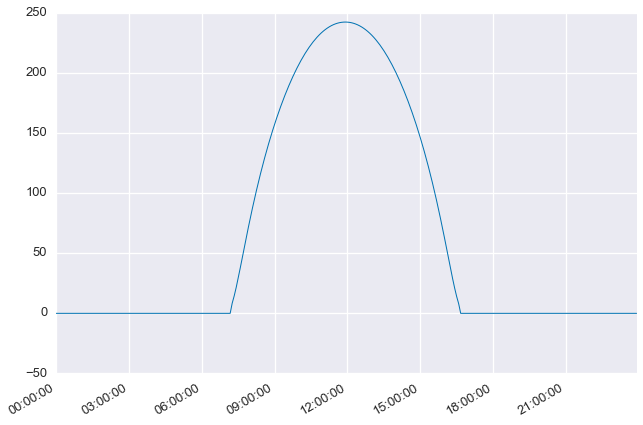

In [11]:
mc.ac.loc['2016-01-01':'2016-01-01'].plot(linewidth=1)

In [12]:
D = mc.ac.as_matrix()[:-1].reshape(288, -1, order='F')
p = mc.ac.as_matrix()

In [13]:
cloudy_days = np.sort(np.random.choice(np.arange(D.shape[1]), size=int(0.3 * D.shape[1]), replace=False))
C = np.ones_like(D)
for cd in cloudy_days:
    C[:, cd] = np.random.uniform(0, 1.1, C.shape[0])

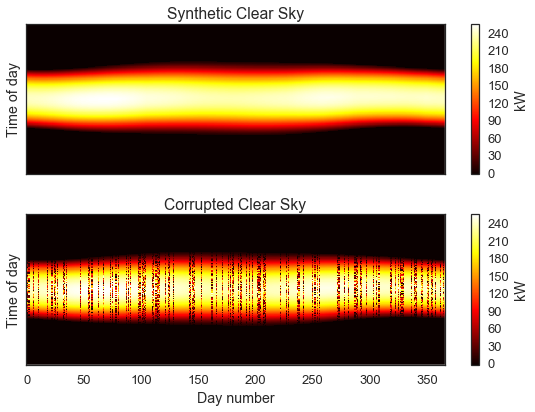

In [14]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(D, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Synthetic Clear Sky')
    bar = ax[1].imshow(np.multiply(D, C), cmap='hot', vmin=0, vmax=np.max(D), interpolation='none', aspect='auto')
    ax[1].set_title('Corrupted Clear Sky')
    plt.colorbar(foo, ax=ax[0], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[1], label='kW')#, ticks=range(0, 30, 5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

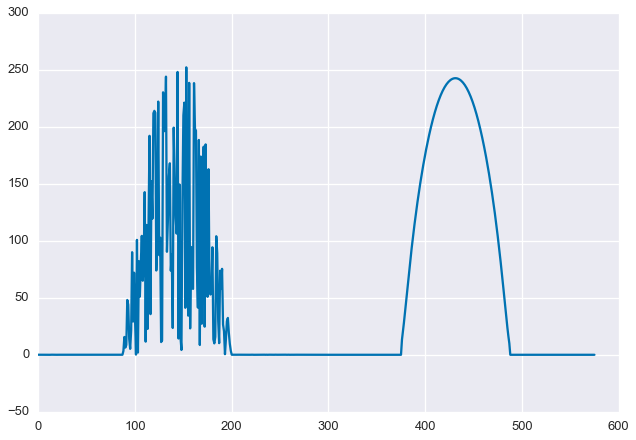

In [15]:
plt.plot(np.multiply(D, C)[:, 2:4].ravel(order='F'))

In [16]:
ics = IterativeClearSky(D * C, k=5)

In [17]:
ics.mu_L = 5e2
ics.mu_R = 1e3
ics.tau = 0.9
ics.minimize_objective(max_iter=20)

starting at 19671198.048 [26487.901665301168, 1772.763836891626, 19642937.382278647, 0]
iteration 1: 9551.037 [7164.118   19.948 2366.971    0.   ]
iteration 2: 7268.293 [4778.254   22.671 2467.369    0.   ]
iteration 3: 6606.079 [4072.905   29.684 2503.489    0.   ]
iteration 4: 6218.875 [3728.308   40.615 2449.952    0.   ]
iteration 5: 5919.639 [3453.953   53.58  2412.105    0.   ]
iteration 6: 5743.266 [3266.223   60.12  2416.924    0.   ]
iteration 7: 5645.736 [3159.582   61.792 2424.362    0.   ]
iteration 8: 5581.646 [3094.217   63.073 2424.356    0.   ]
iteration 9: 5518.390 [3030.2     65.065 2423.125    0.   ]
iteration 10: 5452.226 [2964.097   68.07  2420.059    0.   ]
iteration 11: 5384.742 [2893.047   72.962 2418.733    0.   ]
iteration 12: 5324.840 [2823.284   79.866 2421.69     0.   ]
iteration 13: 5270.589 [2760.546   86.415 2423.628    0.   ]
iteration 14: 5210.648 [2687.166   92.522 2430.959    0.   ]
iteration 15: 5145.422 [2611.304   97.379 2436.739    0.   ]
iterat

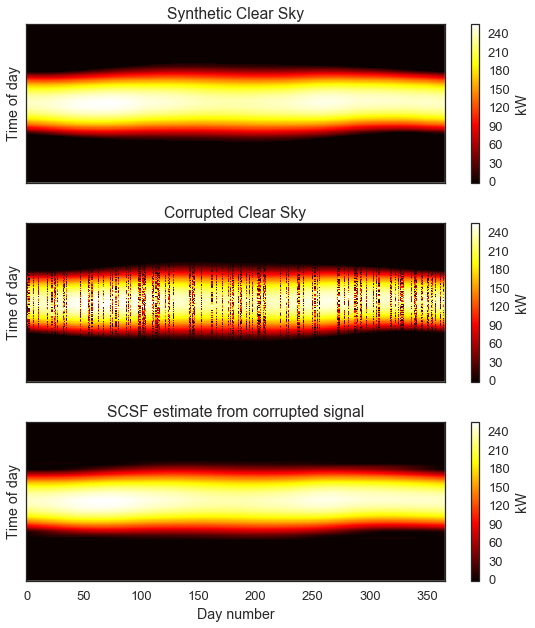

In [18]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=3, figsize=(8,9), sharex=True)
    foo = ax[0].imshow(D, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Synthetic Clear Sky')
    bar = ax[2].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot', vmin=0, vmax=np.max(D), interpolation='none', aspect='auto')
    ax[2].set_title('SCSF estimate from corrupted signal')
    fubar = ax[1].imshow(D*C, cmap='hot', interpolation='none', aspect='auto', vmin=0, vmax=np.max(D))
    ax[1].set_title('Corrupted Clear Sky')
    plt.colorbar(foo, ax=ax[0], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[2], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(fubar, ax=ax[1], label='kW')
    ax[2].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    ax[2].set_yticks([])
    ax[2].set_ylabel('Time of day')
    plt.tight_layout()

In [19]:
np.linalg.norm(D - ics.L_cs.value.dot(ics.R_cs.value), 'fro')

617.2315364817799

In [20]:
np.linalg.norm(D, 'fro')

38716.26002106619

In [21]:
np.linalg.norm(D - ics.L_cs.value.dot(ics.R_cs.value), 'fro') / np.linalg.norm(D, 'fro')

0.015942437005690466

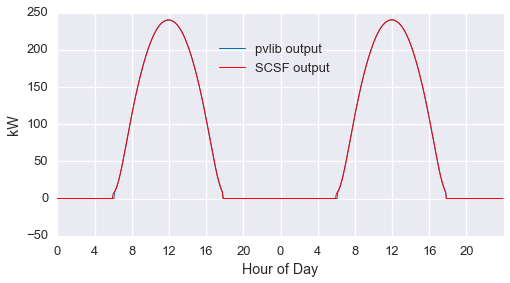

In [22]:
D1 = 205
D2 = D1 + 2
actual = p[D1*288:D2*288]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F').A1
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='pvlib output')
ax.plot(clearsky, linewidth=1, color='red', label='SCSF output')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

(0, 288)

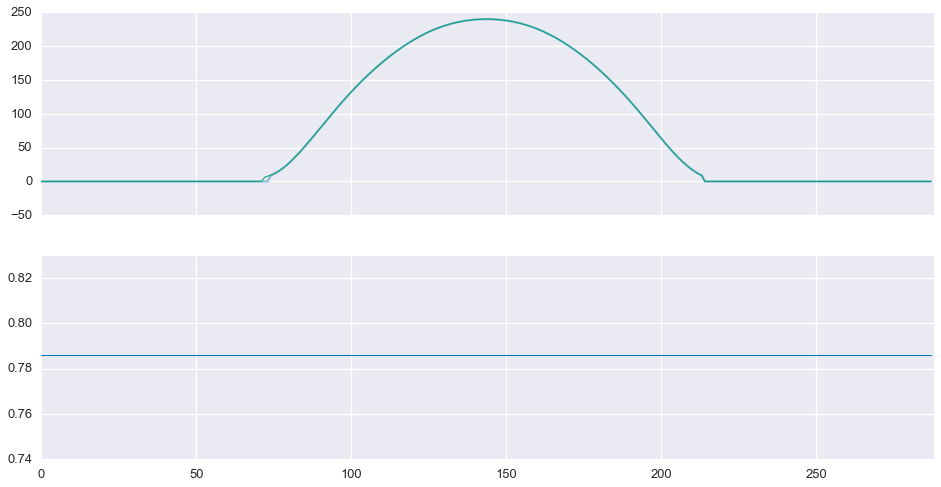

In [23]:
D1 = 205
D2 = D1+1
actual = p[D1*288:D2*288]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F').A1
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))